# Setup
---

## Module Imports

In [1]:
import pandas as pd
import random
import numpy as np

from treetime import wrappers

import matplotlib.pyplot as plt

from Bio import Phylo

## Constants and Variables

In [2]:
name_column = "strain"
#dates_column = "BioSampleCollectionDate"
attribute = "BioSampleBiovar"
missing_data = "?"
file_prefix = "mugration-biovar"
# divtree or timetree
tree_type = "divtree"

NUM_SAMPLE_REMOVE = 20

random.seed(1753143)

## Input File Paths

In [3]:
states_path = "../Assembly_Modern/nextstrain/metadata_nextstrain_geocode_state.tsv"
tree_path = "autocorrelated-relaxed-clock_{}.nexus".format(tree_type)

## Parse Files

In [4]:
states = pd.read_csv(states_path, sep='\t' if states_path[-3:]=='tsv' else ',', skipinitialspace=True)
if name_column in states.columns:
    taxon_name = name_column
if attribute in states.columns:
    attr = attribute

# Get tips names
tree = Phylo.read(tree_path, "nexus")
tree_tip_names = [t.name for t in tree.get_terminals()]

## Run Mugration

In [5]:
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                    if x[attr]!=missing_data and x[attr]}

mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree_path, 
                                                                     leaf_to_attr, 
                                                                     missing_data=missing_data,
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
unique_states = sorted(letter_to_state.values())


0.00	-TreeAnc: set-up
Assigned discrete traits to 267 out of 468 taxa.


0.10	-SequenceData: loaded alignment.

0.10	-SeqData: making compressed alignment...

0.10	-SequenceData: constructed compressed alignment...

0.11	-TreeAnc.infer_ancestral_sequences with method: ml, marginal
0.11	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
0.11	---Attaching sequence profiles to leafs...
0.11	---Postorder: computing likelihoods...
0.14	---Computing root node sequence and total tree likelihood...
0.14	---Preorder: computing marginal profiles...
0.16	---TreeAnc._ml_anc_marginal: ...done
0.20	--TreeAnc.infer_gtr: counting mutations...
0.24	---TreeAnc.infer_gtr: counting mutations...done

0.24	-GTR: with alphabet: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
0.24	--GTR: ambiguous character: K
0.24	----GTR: no gap symbol!
0.24	---GTR: init with dummy values!

0.24	-GTR: model inference
0.24	---GTR inference iteration 0 change: 0.31622776601683794
0.24	---GTR inference iteration 

1.33	---Computing root node sequence and total tree likelihood...
1.33	---Attaching sequence profiles to leafs...
1.34	---Postorder: computing likelihoods...
1.36	---Computing root node sequence and total tree likelihood...
1.36	---Attaching sequence profiles to leafs...
1.36	---Postorder: computing likelihoods...
1.39	---Computing root node sequence and total tree likelihood...
1.39	---Attaching sequence profiles to leafs...
1.39	---Postorder: computing likelihoods...
1.42	---Computing root node sequence and total tree likelihood...

1.42	-treeanc:optimize_gtr_rate: optimization successful. Overall rate estimated
    	 to be 42.420416
1.42	--TreeAnc.infer_gtr: counting mutations...
1.46	---TreeAnc.infer_gtr: counting mutations...done

1.46	-GTR: with alphabet: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
1.47	--GTR: ambiguous character: K
1.47	----GTR: no gap symbol!
1.47	---GTR: init with dummy values!

1.47	-GTR: model inference
1.47	---GTR inference iteration 0 change: 0.3162

2.61	---Attaching sequence profiles to leafs...
2.61	---Postorder: computing likelihoods...
2.64	---Computing root node sequence and total tree likelihood...
2.64	---Attaching sequence profiles to leafs...
2.65	---Postorder: computing likelihoods...
2.67	---Computing root node sequence and total tree likelihood...
2.67	---Attaching sequence profiles to leafs...
2.68	---Postorder: computing likelihoods...
2.71	---Computing root node sequence and total tree likelihood...
2.71	---Attaching sequence profiles to leafs...
2.71	---Postorder: computing likelihoods...
2.75	---Computing root node sequence and total tree likelihood...
2.75	---Attaching sequence profiles to leafs...
2.75	---Postorder: computing likelihoods...
2.78	---Computing root node sequence and total tree likelihood...
2.78	---Attaching sequence profiles to leafs...
2.78	---Postorder: computing likelihoods...
2.82	---Computing root node sequence and total tree likelihood...
2.82	---Attaching sequence profiles to leafs...
2.82

## Add Node Comments

In [6]:
terminal_count = 0
for n in mug.tree.find_clades():
    if n.up is None:
        continue
    mug_comment = '%s="'%attr + letter_to_state[n.cseq[0]] +'"'
    if not n.comment:
        n.comment= "".join(["&", mug_comment])
    else:
        n.comment = ",".join([n.comment, mug_comment])

## File Export

In [7]:
# Write GTR File
with open("{}_gtr.txt".format(file_prefix), 'w') as ofile:
    ofile.write('Character to attribute mapping:\n')
    for state in unique_states:
        ofile.write('  %s: %s\n'%(reverse_alphabet[state], state))    
    ofile.write('\n\n'+str(mug.gtr)+'\n')
    
# Write Confidence File
with open("{}_confidence.csv".format(file_prefix), 'w') as ofile:
    named_header = [
                   letter_to_state[char] for char in letter_to_state
                   if not letter_to_state[char] == missing_data
                   ]
    ofile.write('#name, '+', '.join(named_header) +'\n')
    for n in mug.tree.find_clades():
        ofile.write(n.name + ', '+', '.join([str(x) for x in n.marginal_profile[0]])+'\n')

# Write Tree File
Phylo.write(mug.tree, 
            "{}_{}.nexus".format(file_prefix, tree_type), 
            "nexus",
            format_branch_length='%1.10f')


# Figtree compatible timetrees
for c in mug.tree.find_clades():
    # Make sure all branches have length (not None)
    if c.branch_length is None:
        c.branch_length = 0
    # Remove internal node names
    if not c.is_terminal():
        c.name = None
        
Phylo.write(mug.tree, 
            "{}_{}-plain.nexus".format(file_prefix, tree_type), 
            "nexus", 
            format_branch_length='%1.10f')     
#------------------

1

# Leave One Out - Biovar

## Setup

In [8]:
attribute = "BioSampleBiovar"
file_prefix = "mugration-biovar"

states = pd.read_csv(states_path, sep='\t' if states_path[-3:]=='tsv' else ',', skipinitialspace=True)
if name_column in states.columns:
    taxon_name = name_column
if attribute in states.columns:
    attr = attribute
    
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                if x[attr]!=missing_data and x[attr]}

## Randomly select the tip samples

In [9]:
dict_sample_remove = {}

for i in range(0,NUM_SAMPLE_REMOVE):
    
    # Retrieve tip name and val (date)
    tip = random.choice(list(leaf_to_attr.keys()))
    tip_val = leaf_to_attr[tip]
    
    # Check that it is not already missing data
    # And that it is actually in the input tree
    while tip_val == missing_data or tip not in tree_tip_names:
        tip = random.choice(list(leaf_to_attr.keys()))
        tip_val = leaf_to_attr[tip] 
        
    dict_sample_remove[tip] = tip_val
    
    # Remove the metadata from the dates object
    leaf_to_attr[tip] = missing_data

## Run Mugration

In [10]:
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree_path, 
                                                                     leaf_to_attr, 
                                                                     missing_data=missing_data,
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
unique_states = sorted(letter_to_state.values())


0.00	-TreeAnc: set-up
Assigned discrete traits to 244 out of 468 taxa.


0.10	-SequenceData: loaded alignment.

0.10	-SeqData: making compressed alignment...

0.10	-SequenceData: constructed compressed alignment...

0.11	-TreeAnc.infer_ancestral_sequences with method: ml, marginal
0.11	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
0.11	---Attaching sequence profiles to leafs...
0.11	---Postorder: computing likelihoods...
0.13	---Computing root node sequence and total tree likelihood...
0.14	---Preorder: computing marginal profiles...
0.16	---TreeAnc._ml_anc_marginal: ...done
0.20	--TreeAnc.infer_gtr: counting mutations...
0.24	---TreeAnc.infer_gtr: counting mutations...done

0.24	-GTR: with alphabet: ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
0.24	--GTR: ambiguous character: K
0.24	----GTR: no gap symbol!
0.24	---GTR: init with dummy values!

0.24	-GTR: model inference
0.24	---GTR inference iteration 0 change: 0.31622776601683794
0.24	---GTR inference iteration 

1.41	---Computing root node sequence and total tree likelihood...
1.41	---Attaching sequence profiles to leafs...
1.41	---Postorder: computing likelihoods...
1.44	---Computing root node sequence and total tree likelihood...
1.44	---Attaching sequence profiles to leafs...
1.44	---Postorder: computing likelihoods...
1.46	---Computing root node sequence and total tree likelihood...
1.46	---Attaching sequence profiles to leafs...
1.47	---Postorder: computing likelihoods...
1.49	---Computing root node sequence and total tree likelihood...
1.49	---Attaching sequence profiles to leafs...
1.49	---Postorder: computing likelihoods...
1.51	---Computing root node sequence and total tree likelihood...
1.52	---Attaching sequence profiles to leafs...
1.52	---Postorder: computing likelihoods...
1.55	---Computing root node sequence and total tree likelihood...
1.55	---Attaching sequence profiles to leafs...
1.55	---Postorder: computing likelihoods...
1.58	---Computing root node sequence and total tree 

2.58	---Computing root node sequence and total tree likelihood...
2.58	---Attaching sequence profiles to leafs...
2.59	---Postorder: computing likelihoods...
2.61	---Computing root node sequence and total tree likelihood...
2.61	---Attaching sequence profiles to leafs...
2.61	---Postorder: computing likelihoods...
2.63	---Computing root node sequence and total tree likelihood...
2.63	---Attaching sequence profiles to leafs...
2.63	---Postorder: computing likelihoods...
2.67	---Computing root node sequence and total tree likelihood...
2.67	---Attaching sequence profiles to leafs...
2.68	---Postorder: computing likelihoods...
2.71	---Computing root node sequence and total tree likelihood...
2.71	---Attaching sequence profiles to leafs...
2.72	---Postorder: computing likelihoods...
2.75	---Computing root node sequence and total tree likelihood...
2.75	---Attaching sequence profiles to leafs...
2.76	---Postorder: computing likelihoods...
2.79	---Computing root node sequence and total tree 

## Add Node Comments

## Plot Comparison

In [11]:
terminal_count = 0
for n in mug.tree.find_clades():
    if n.up is None:
        continue
    mug_comment = '%s="'%attr + letter_to_state[n.cseq[0]] +'"'
    if not n.comment:
        n.comment= "".join(["&", mug_comment])
    else:
        n.comment = ",".join([n.comment, mug_comment])

In [12]:
dict_sample_estimate = {}
dict_mug_contain_sample_val = {}

# Get the terminal nodes from the estimated relaxed clock model
for t in mug.tree.get_terminals():
    if t.name in dict_sample_remove:
        sample_val = dict_sample_remove[t.name]
        dict_sample_estimate[t.name] = {'sample_val': sample_val,
                                        'estimate_val': letter_to_state[t.cseq[0]]
                                       }
        if dict_sample_estimate[t.name]['sample_val'] == dict_sample_estimate[t.name]['estimate_val']:
            dict_mug_contain_sample_val[t.name] = dict_sample_remove[t.name]
            
perc_mug_contain_sample_val = (len(dict_mug_contain_sample_val) / len(dict_sample_estimate)) * 100

In [13]:
# Scatter plot of actual sampling dates

list_sample_name = list(dict_sample_estimate.keys())
list_sample_val = [dict_sample_estimate[sample]['sample_val'] for sample in dict_sample_estimate]
list_estimate_val = [dict_sample_estimate[sample]['estimate_val'] for sample in dict_sample_estimate]

list_conf_val = []

for c in mug.tree.find_clades():
    if c.name in dict_sample_remove.keys():
        max_conf = max(c.marginal_profile[0]) * 100
        list_conf_val.append(max_conf)

list_conf_str = ['{:.0f}'.format(x) for x in list_conf_val]

/home/ktmeaton/miniconda3/envs/nextstrain-8.0.0/lib/python3.6/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


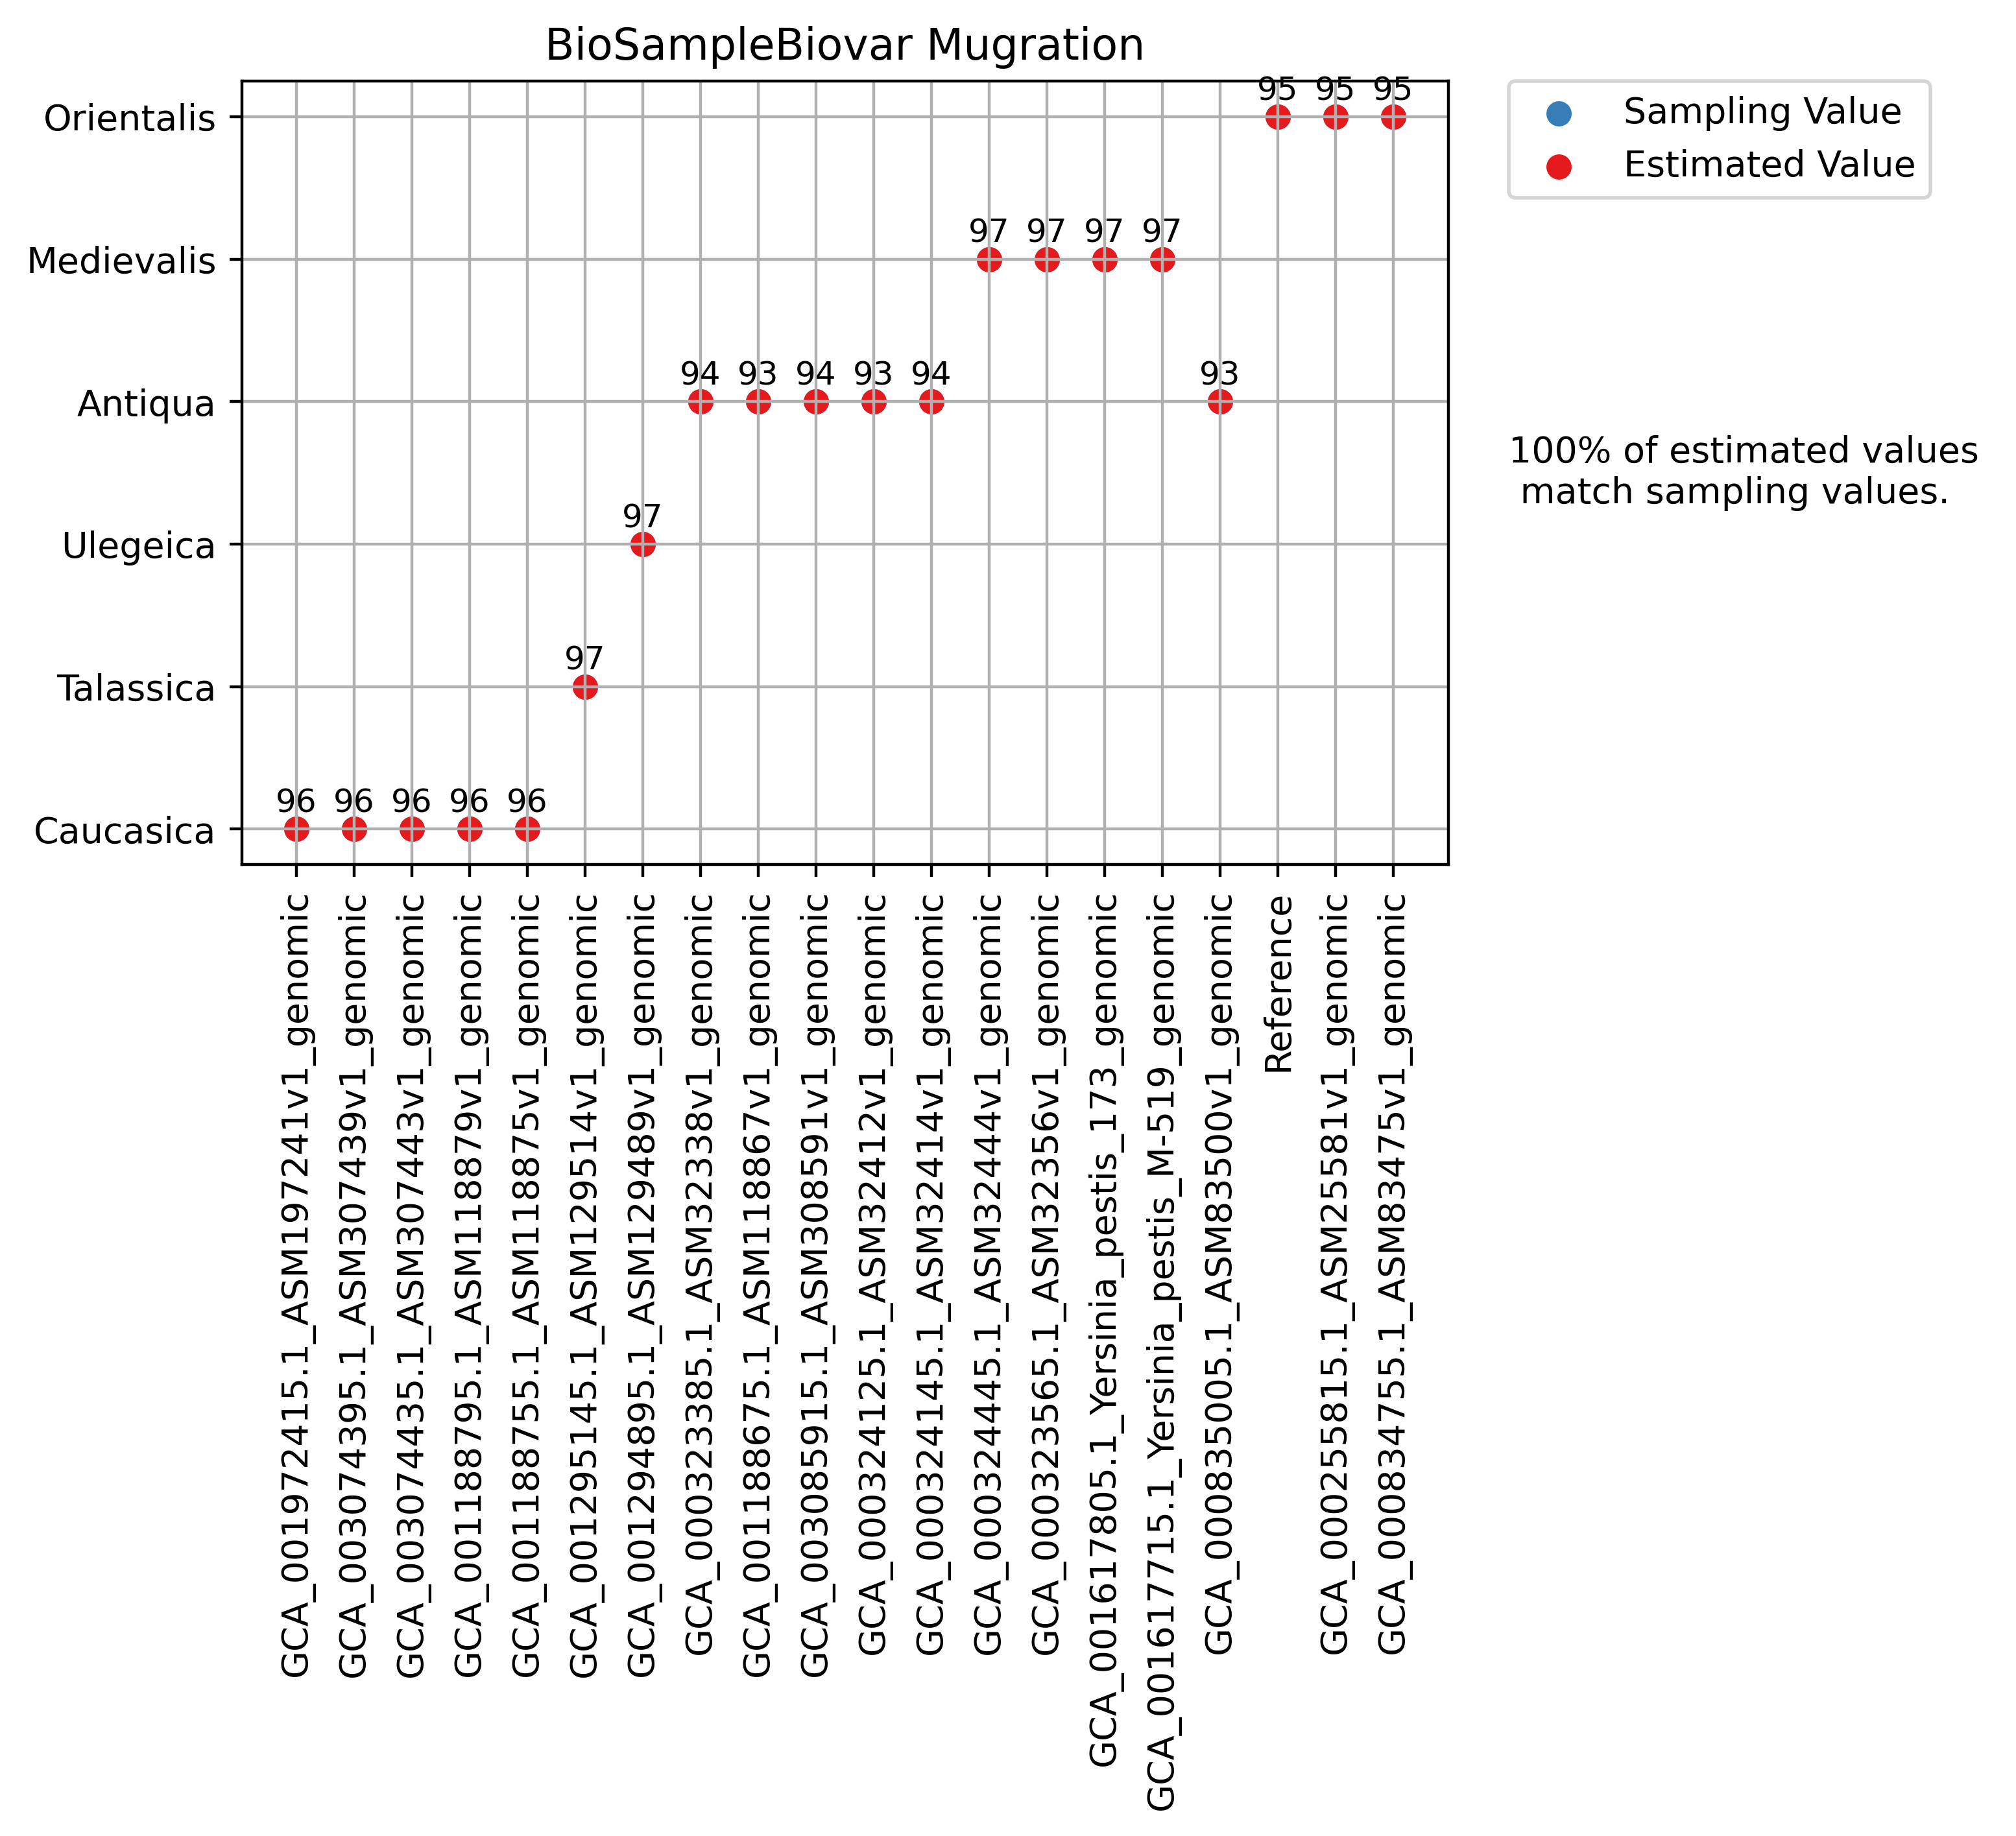

In [14]:
plt.figure(dpi=400)
ax = plt.subplot()


# Sampling val scatter plot
scatter_sample = plt.scatter(x=list_sample_name, y=list_sample_val, c="#377eb8", label = "Sampling Value")

# Estimated val scatter plot
plt.scatter(x=list_sample_name, y=list_estimate_val, c="#e41a1c", label = "Estimated Value", )

perc_string = "{0:.0f}% of estimated values \n match sampling values.".format(perc_mug_contain_sample_val)
                                                                                
# Add text
plt.text(1.05, 0.5, 
         perc_string, 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform=ax.transAxes)

# Add text conf labels
for i in range(0, len(list_conf_str)):
    ax.annotate(list_conf_str[i],
                xy=(list_sample_name[i], list_estimate_val[i]), 
                xycoords='data',
                #xytext=(list_sample_name[i],list_estimate_val[i]),
                xytext=(0,40),
                textcoords='offset pixels',
                fontsize=9,
                horizontalalignment='center', 
                verticalalignment='center')

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)
# Title
plt.title("{} Mugration".format(attribute))
plt.savefig("{}_tip-estimation.png".format(file_prefix), dpi=400, bbox_inches = "tight")

# Leave One Out - Country

## Setup

In [15]:
attribute = "country"
file_prefix = "mugration-country"

states = pd.read_csv(states_path, sep='\t' if states_path[-3:]=='tsv' else ',', skipinitialspace=True)
if name_column in states.columns:
    taxon_name = name_column
if attribute in states.columns:
    attr = attribute
    
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                if x[attr]!=missing_data and x[attr]}

## Use Tips Previously Selected

In [16]:
dict_sample_remove = {}

for i in range(0,NUM_SAMPLE_REMOVE):
    
    # Retrieve tip name and val (date)
    tip = random.choice(list(leaf_to_attr.keys()))
    tip_val = leaf_to_attr[tip]
    
    # Check that it is not already missing data
    # And that it is actually in the input tree
    while tip_val == missing_data or tip not in tree_tip_names:
        tip = random.choice(list(leaf_to_attr.keys()))
        tip_val = leaf_to_attr[tip] 
        
    dict_sample_remove[tip] = tip_val
    
    # Remove the metadata from the dates object
    leaf_to_attr[tip] = missing_data

## Run Mugration

In [17]:
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree_path, 
                                                                     leaf_to_attr, 
                                                                     missing_data=missing_data,
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
unique_states = sorted(letter_to_state.values())


0.00	-TreeAnc: set-up
Assigned discrete traits to 409 out of 468 taxa.


0.16	-SequenceData: loaded alignment.

0.16	-SeqData: making compressed alignment...

0.16	-SequenceData: constructed compressed alignment...

0.17	-TreeAnc.infer_ancestral_sequences with method: ml, marginal
0.17	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
0.17	---Attaching sequence profiles to leafs...
0.18	---Postorder: computing likelihoods...
0.22	---Computing root node sequence and total tree likelihood...
0.22	---Preorder: computing marginal profiles...
0.26	---TreeAnc._ml_anc_marginal: ...done
0.31	--TreeAnc.infer_gtr: counting mutations...
0.38	---TreeAnc.infer_gtr: counting mutations...done

0.38	-GTR: with alphabet: ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    	 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    	 '[', '\\', ']']
0.38	--GTR: ambiguous character: ]
0.38	----GTR: no gap symbol!
0.38	---GTR: init with dummy values!

0.38	-GTR: model i

1.98	---Computing root node sequence and total tree likelihood...

1.98	-treeanc:optimize_gtr_rate: optimization successful. Overall rate estimated
    	 to be 99.278190
1.99	--TreeAnc.infer_gtr: counting mutations...
2.05	---TreeAnc.infer_gtr: counting mutations...done

2.05	-GTR: with alphabet: ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    	 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    	 '[', '\\', ']']
2.05	--GTR: ambiguous character: ]
2.05	----GTR: no gap symbol!
2.05	---GTR: init with dummy values!

2.05	-GTR: model inference
2.05	---GTR inference iteration 0 change: 0.1889822365046136
2.05	---GTR inference iteration 1 change: 0.024249124141904683
2.05	---GTR inference iteration 2 change: 0.0010996517285891618
2.05	---GTR inference iteration 3 change: 0.0001233682642587483
2.05	---Attaching sequence profiles to leafs...
2.05	---Postorder: computing likelihoods...
2.08	---Computing root node sequence and total tree likelihood...
2.08	---A

3.43	---Computing root node sequence and total tree likelihood...
3.43	---Attaching sequence profiles to leafs...
3.44	---Postorder: computing likelihoods...
3.47	---Computing root node sequence and total tree likelihood...
3.47	---Attaching sequence profiles to leafs...
3.48	---Postorder: computing likelihoods...
3.52	---Computing root node sequence and total tree likelihood...
3.52	---Attaching sequence profiles to leafs...
3.52	---Postorder: computing likelihoods...
3.56	---Computing root node sequence and total tree likelihood...
3.56	---Attaching sequence profiles to leafs...
3.56	---Postorder: computing likelihoods...
3.59	---Computing root node sequence and total tree likelihood...
3.59	---Attaching sequence profiles to leafs...
3.59	---Postorder: computing likelihoods...
3.62	---Computing root node sequence and total tree likelihood...
3.62	---Attaching sequence profiles to leafs...
3.62	---Postorder: computing likelihoods...
3.65	---Computing root node sequence and total tree 

## Plot Comparison

In [18]:
terminal_count = 0
for n in mug.tree.find_clades():
    if n.up is None:
        continue
    mug_comment = '%s="'%attr + letter_to_state[n.cseq[0]] +'"'
    if not n.comment:
        n.comment= "".join(["&", mug_comment])
    else:
        n.comment = ",".join([n.comment, mug_comment])

In [19]:
dict_sample_estimate = {}
dict_mug_contain_sample_val = {}

# Get the terminal nodes from the estimated relaxed clock model
for t in mug.tree.get_terminals():
    if t.name in dict_sample_remove:
        sample_val = dict_sample_remove[t.name]
        dict_sample_estimate[t.name] = {'sample_val': sample_val,
                                        'estimate_val': letter_to_state[t.cseq[0]]
                                       }
        if dict_sample_estimate[t.name]['sample_val'] == dict_sample_estimate[t.name]['estimate_val']:
            dict_mug_contain_sample_val[t.name] = dict_sample_remove[t.name]
            
perc_mug_contain_sample_val = (len(dict_mug_contain_sample_val) / len(dict_sample_estimate)) * 100

In [20]:
# Scatter plot of actual sampling dates

list_sample_name = list(dict_sample_estimate.keys())
list_sample_val = [dict_sample_estimate[sample]['sample_val'] for sample in dict_sample_estimate]
list_estimate_val = [dict_sample_estimate[sample]['estimate_val'] for sample in dict_sample_estimate]


list_conf_val = []

for c in mug.tree.find_clades():
    if c.name in dict_sample_remove.keys():
        max_conf = max(c.marginal_profile[0]) * 100
        list_conf_val.append(max_conf)

list_conf_str = ['{:.0f}'.format(x) for x in list_conf_val]

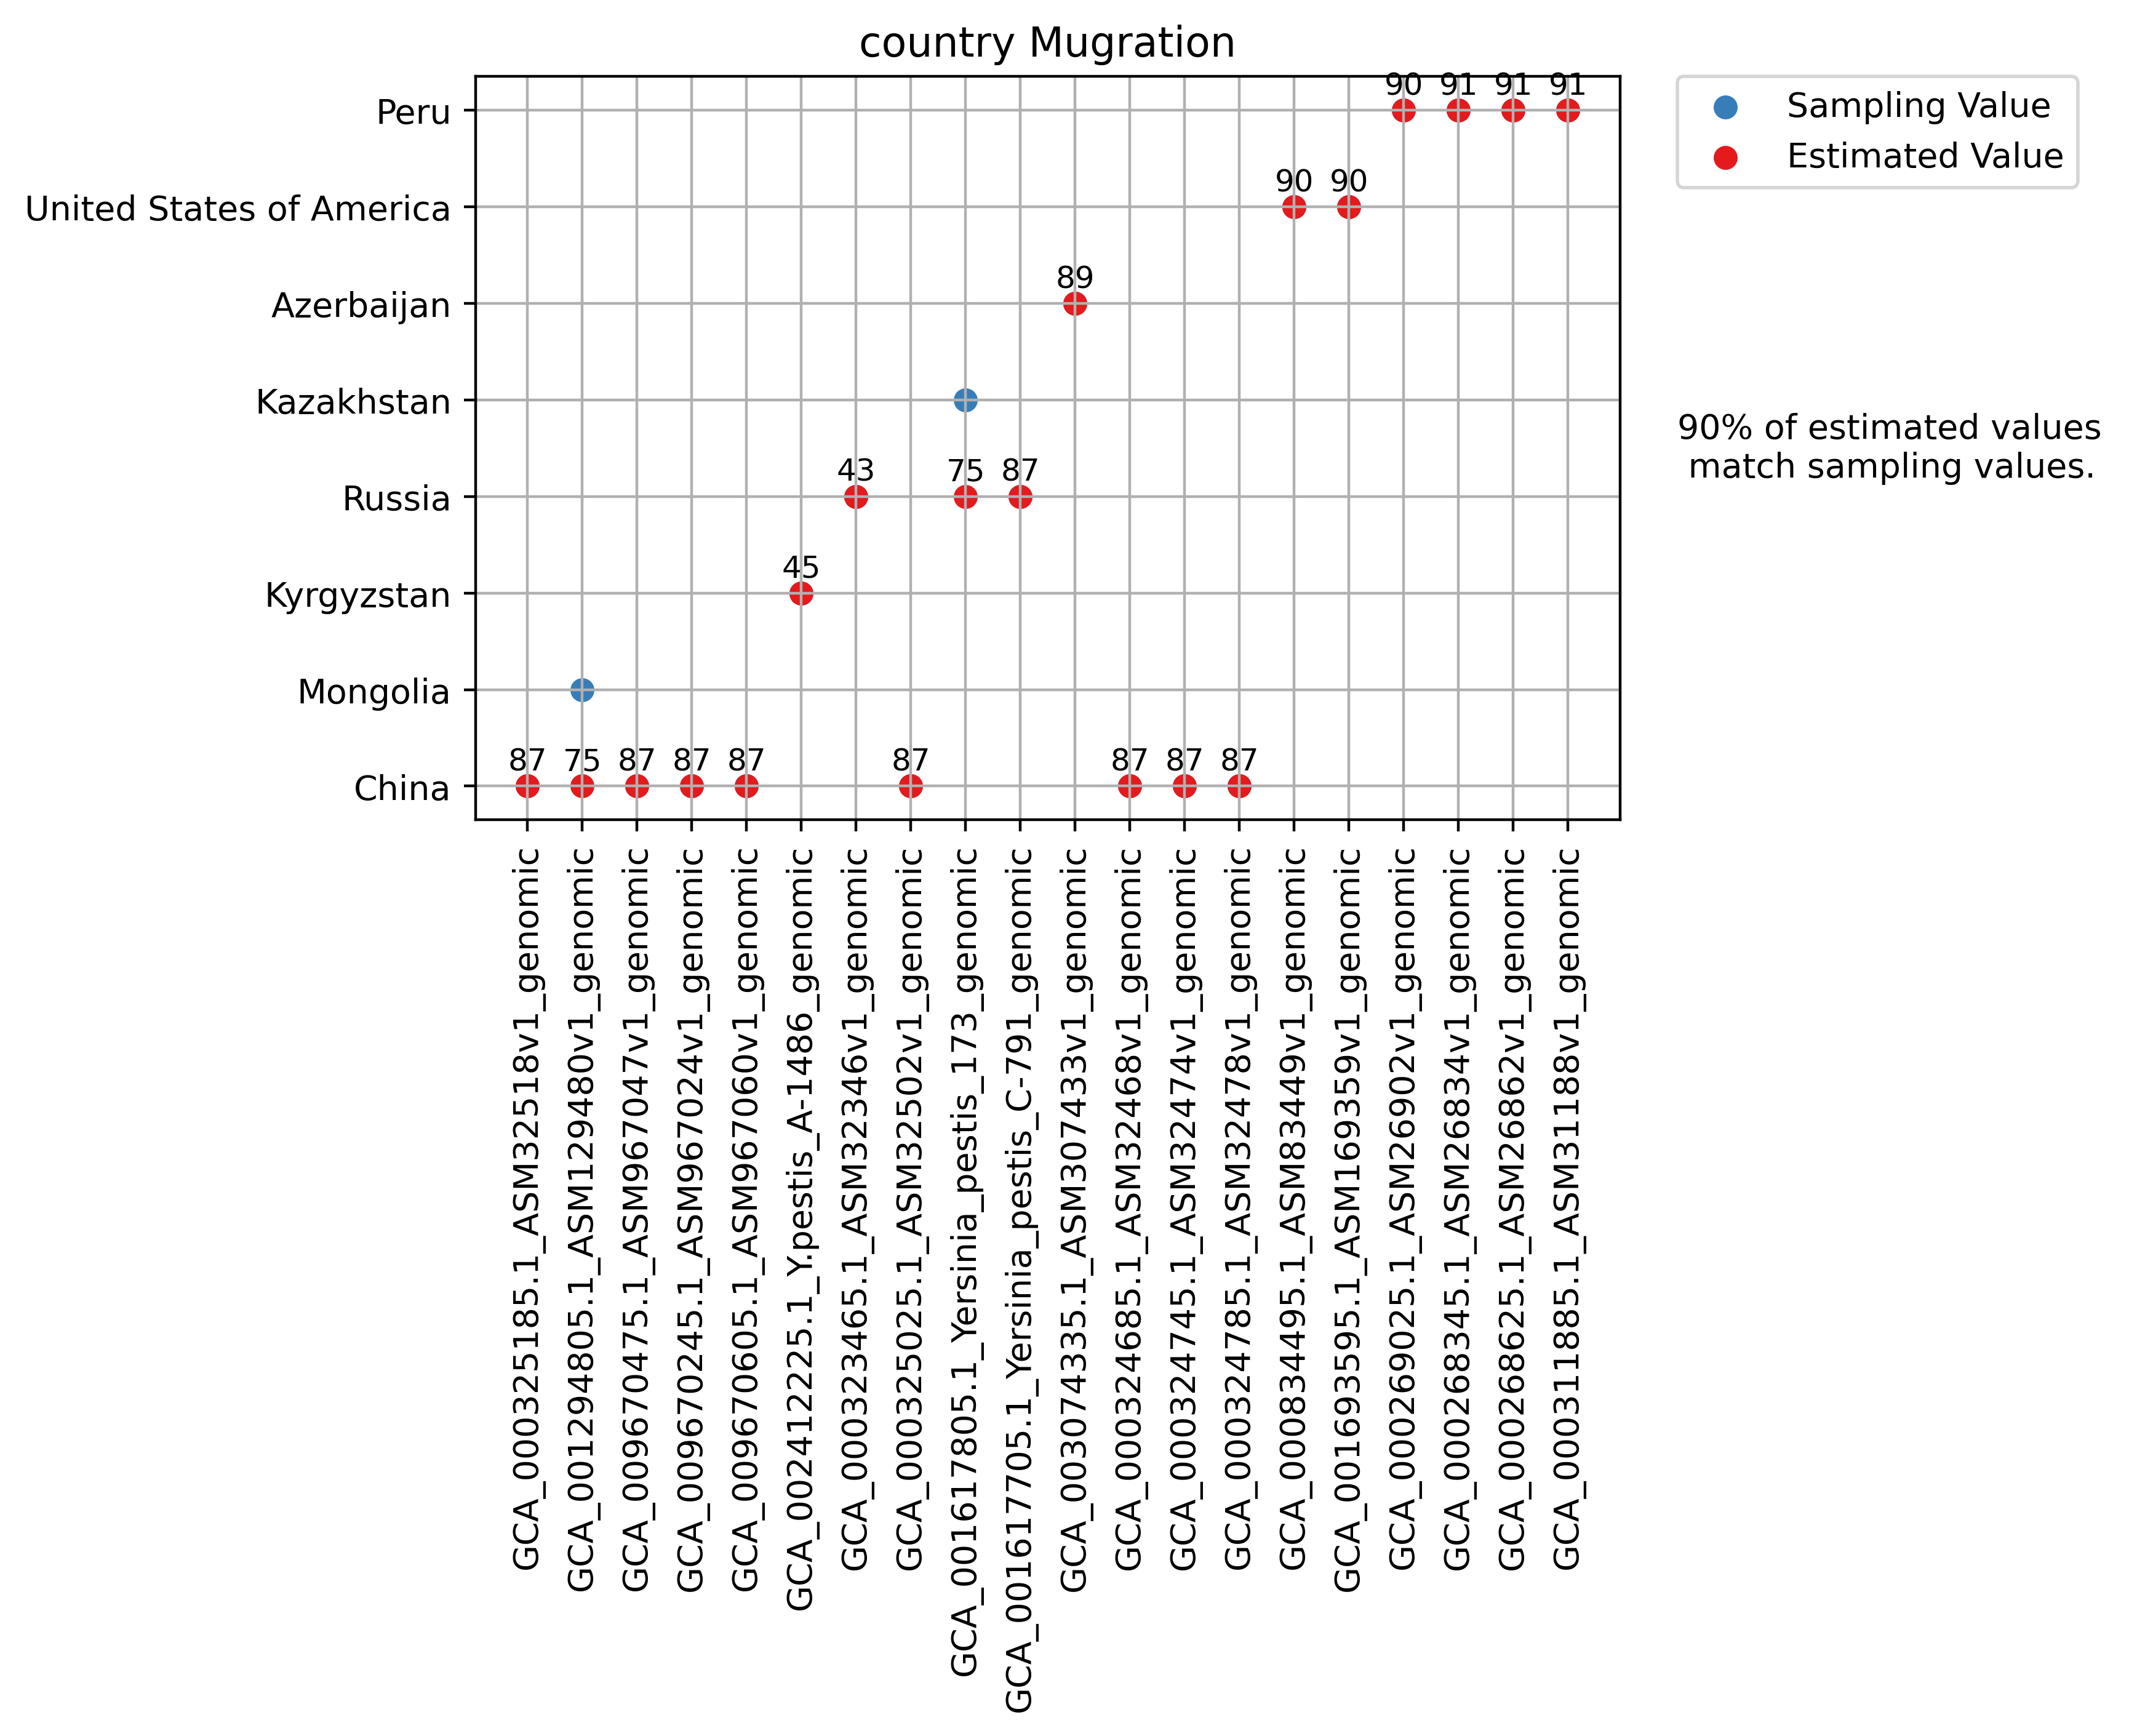

In [21]:
plt.figure(dpi=400)
ax = plt.subplot()


# Sampling val scatter plot
scatter_sample = plt.scatter(x=list_sample_name, y=list_sample_val, c="#377eb8", label = "Sampling Value")

# Estimated val scatter plot
plt.scatter(x=list_sample_name, y=list_estimate_val, c="#e41a1c", label = "Estimated Value", )

perc_string = "{0:.0f}% of estimated values \n match sampling values.".format(perc_mug_contain_sample_val)
                                                                                
# Add text
plt.text(1.05, 0.5, 
         perc_string, 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform=ax.transAxes)

# Add text conf labels
for i in range(0, len(list_conf_str)):
    ax.annotate(list_conf_str[i],
                xy=(list_sample_name[i], list_estimate_val[i]), 
                xycoords='data',
                #xytext=(list_sample_name[i],list_estimate_val[i]),
                xytext=(0,40),
                textcoords='offset pixels',
                fontsize=9,
                horizontalalignment='center', 
                verticalalignment='center')

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)
# Title
plt.title("{} Mugration".format(attribute))
plt.savefig("{}_tip-estimation.png".format(file_prefix), dpi=400, bbox_inches = "tight")

# Leave One Out - State

## Setup

In [22]:
attribute = "state"
file_prefix = "mugration-state"

states = pd.read_csv(states_path, sep='\t' if states_path[-3:]=='tsv' else ',', skipinitialspace=True)
if name_column in states.columns:
    taxon_name = name_column
if attribute in states.columns:
    attr = attribute
    
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                if x[attr]!=missing_data and x[attr]}

## Randomly Select the Tip Samples

In [23]:
dict_sample_remove = {}

for i in range(0,NUM_SAMPLE_REMOVE):
    
    # Retrieve tip name and val (date)
    tip = random.choice(list(leaf_to_attr.keys()))
    tip_val = leaf_to_attr[tip]
    
    # Check that it is not already missing data
    # And that it is actually in the input tree
    while tip_val == missing_data or tip not in tree_tip_names:
        tip = random.choice(list(leaf_to_attr.keys()))
        tip_val = leaf_to_attr[tip] 
        
    dict_sample_remove[tip] = tip_val
    
    # Remove the metadata from the dates object
    leaf_to_attr[tip] = missing_data

## Run Mugration

In [24]:
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree_path, 
                                                                     leaf_to_attr, 
                                                                     missing_data=missing_data,
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
unique_states = sorted(letter_to_state.values())


0.00	-TreeAnc: set-up
Assigned discrete traits to 393 out of 468 taxa.


0.11	-SequenceData: loaded alignment.

0.11	-SeqData: making compressed alignment...

0.12	-SequenceData: constructed compressed alignment...

0.13	-TreeAnc.infer_ancestral_sequences with method: ml, marginal
0.13	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
0.13	---Attaching sequence profiles to leafs...
0.13	---Postorder: computing likelihoods...
0.19	---Computing root node sequence and total tree likelihood...
0.19	---Preorder: computing marginal profiles...
0.24	---TreeAnc._ml_anc_marginal: ...done
0.28	--TreeAnc.infer_gtr: counting mutations...
0.40	---TreeAnc.infer_gtr: counting mutations...done

0.40	-GTR: with alphabet: ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    	 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    	 '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
    	 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',

3.35	---TreeAnc.infer_gtr: counting mutations...done

3.35	-GTR: with alphabet: ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    	 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    	 '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
    	 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
    	 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x80', '\x81', '\x82', '\x83',
    	 '\x84', '\x85', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b']
3.35	--GTR: ambiguous character: 
3.35	----GTR: no gap symbol!
3.35	---GTR: init with dummy values!

3.35	-GTR: model inference
3.35	---GTR inference iteration 0 change: 0.11624763874381928
3.35	---GTR inference iteration 1 change: 0.004529195212646363
3.35	---GTR inference iteration 2 change: 6.630346107647116e-05
3.36	---Attaching sequence profiles to leafs...
3.36	---Postorder: computing likelihoods...
3.41	---Computing root node sequence and total tree likelihood...
3.4

6.22	---Computing root node sequence and total tree likelihood...
6.22	---Attaching sequence profiles to leafs...
6.22	---Postorder: computing likelihoods...
6.29	---Computing root node sequence and total tree likelihood...
6.29	---Attaching sequence profiles to leafs...
6.30	---Postorder: computing likelihoods...
6.36	---Computing root node sequence and total tree likelihood...
6.36	---Attaching sequence profiles to leafs...
6.36	---Postorder: computing likelihoods...
6.43	---Computing root node sequence and total tree likelihood...
6.43	---Attaching sequence profiles to leafs...
6.44	---Postorder: computing likelihoods...
6.50	---Computing root node sequence and total tree likelihood...
6.50	---Attaching sequence profiles to leafs...
6.51	---Postorder: computing likelihoods...
6.56	---Computing root node sequence and total tree likelihood...
6.56	---Attaching sequence profiles to leafs...
6.57	---Postorder: computing likelihoods...
6.63	---Computing root node sequence and total tree 

## Plot Comparison

In [25]:
terminal_count = 0
for n in mug.tree.find_clades():
    if n.up is None:
        continue
    mug_comment = '%s="'%attr + letter_to_state[n.cseq[0]] +'"'
    if not n.comment:
        n.comment= "".join(["&", mug_comment])
    else:
        n.comment = ",".join([n.comment, mug_comment])

In [26]:
dict_sample_estimate = {}
dict_mug_contain_sample_val = {}

# Get the terminal nodes from the estimated relaxed clock model
for t in mug.tree.get_terminals():
    if t.name in dict_sample_remove:
        sample_val = dict_sample_remove[t.name]
        dict_sample_estimate[t.name] = {'sample_val': sample_val,
                                        'estimate_val': letter_to_state[t.cseq[0]]
                                       }
        if dict_sample_estimate[t.name]['sample_val'] == dict_sample_estimate[t.name]['estimate_val']:
            dict_mug_contain_sample_val[t.name] = dict_sample_remove[t.name]
            
perc_mug_contain_sample_val = (len(dict_mug_contain_sample_val) / len(dict_sample_estimate)) * 100

In [27]:
# Scatter plot of actual sampling dates

list_sample_name = list(dict_sample_estimate.keys())
list_sample_val = [dict_sample_estimate[sample]['sample_val'] for sample in dict_sample_estimate]
list_estimate_val = [dict_sample_estimate[sample]['estimate_val'] for sample in dict_sample_estimate]

list_conf_val = []

for c in mug.tree.find_clades():
    if c.name in dict_sample_remove.keys():
        max_conf = max(c.marginal_profile[0]) * 100
        list_conf_val.append(max_conf)

list_conf_str = ['{:.0f}'.format(x) for x in list_conf_val]

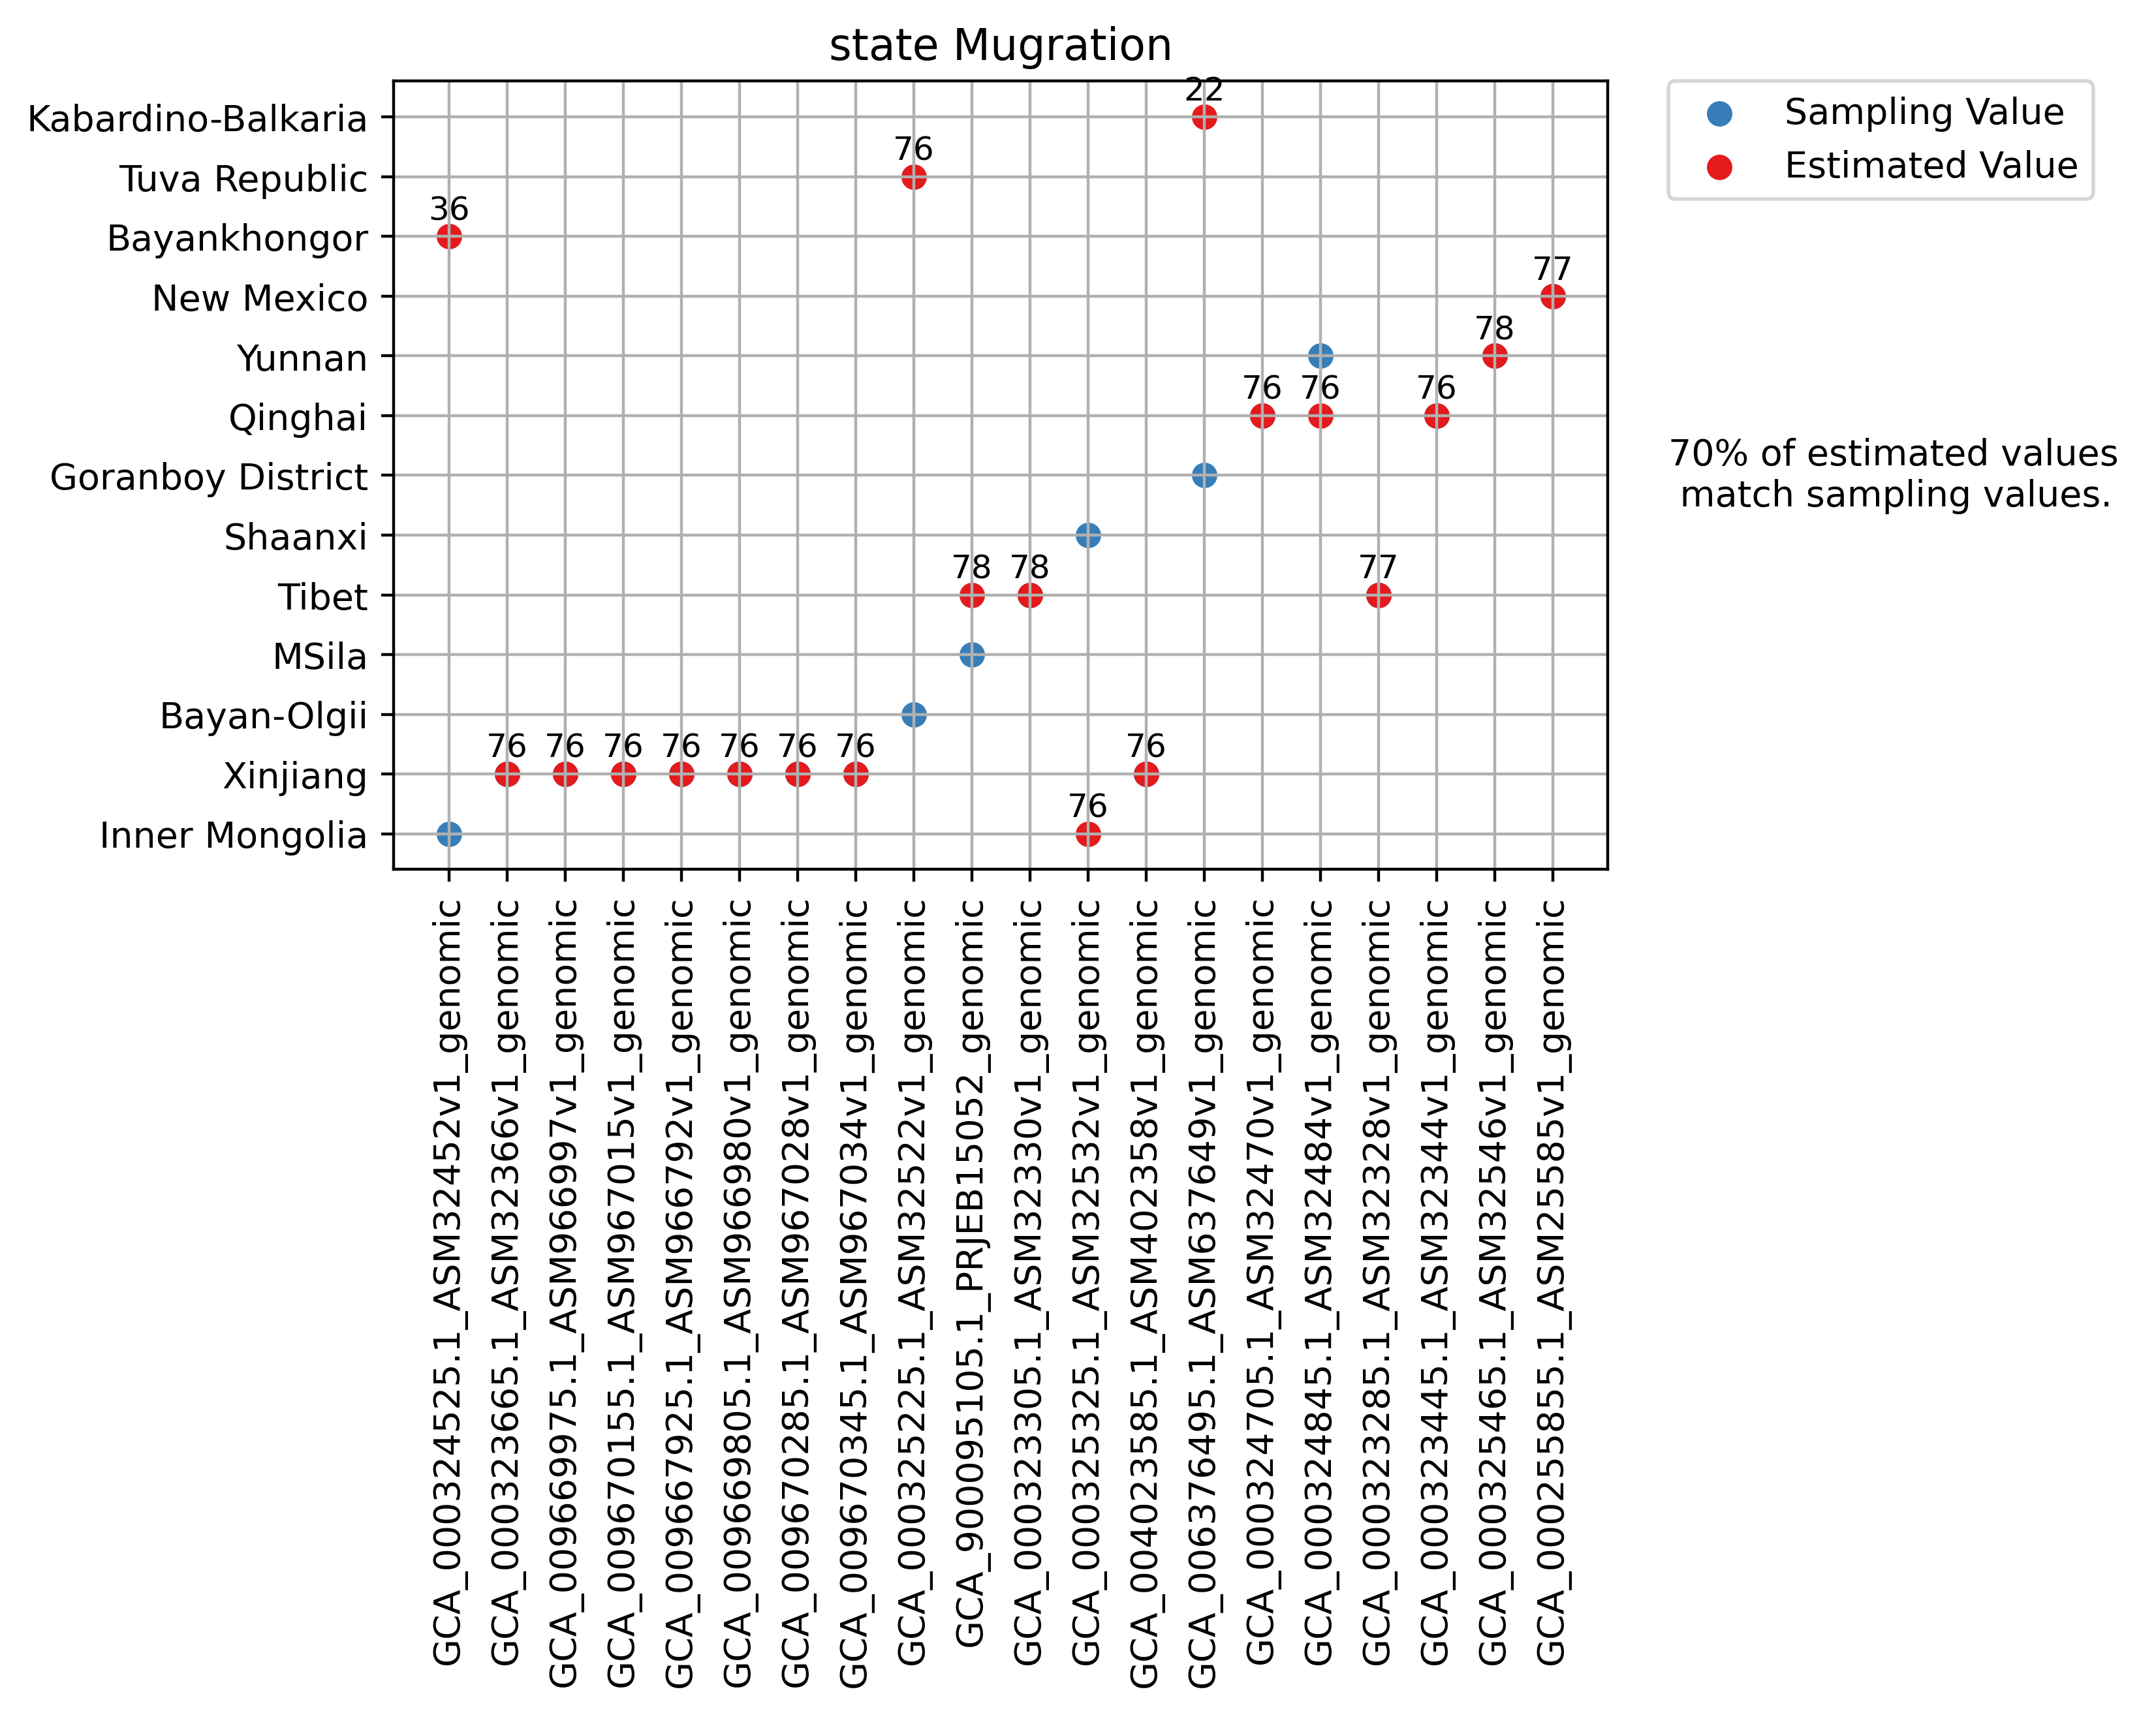

In [28]:
plt.figure(dpi=400)
ax = plt.subplot()


# Sampling val scatter plot
scatter_sample = plt.scatter(x=list_sample_name, y=list_sample_val, c="#377eb8", label = "Sampling Value")

# Estimated val scatter plot
plt.scatter(x=list_sample_name, y=list_estimate_val, c="#e41a1c", label = "Estimated Value", )

perc_string = "{0:.0f}% of estimated values \n match sampling values.".format(perc_mug_contain_sample_val)
                                                                                
# Add text
plt.text(1.05, 0.5, 
         perc_string, 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform=ax.transAxes)

# Add text conf labels
for i in range(0, len(list_conf_str)):
    ax.annotate(list_conf_str[i],
                xy=(list_sample_name[i], list_estimate_val[i]), 
                xycoords='data',
                #xytext=(list_sample_name[i],list_estimate_val[i]),
                xytext=(0,40),
                textcoords='offset pixels',
                fontsize=9,
                horizontalalignment='center', 
                verticalalignment='center')

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)
# Title
plt.title("{} Mugration".format(attribute))
plt.savefig("{}_tip-estimation.png".format(file_prefix), dpi=400, bbox_inches = "tight")